<a href="https://colab.research.google.com/github/ysooch0819/AI16-Projects/blob/main/Section2_project_%ED%95%9C%EC%82%AC%EC%9D%B4%ED%81%B4%EB%8F%8C%EB%A6%B0%EB%B2%84%EC%A0%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import requests
import time
import json
from pandas import json_normalize

In [2]:
import sys

if "google.colab" in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    # !pip install --upgrade xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
# 'info' 안의 'participants' 특성에 해당 게임의 경기에서 8명의 전체유저들이 플레이한 기록이 들어있다.
# 관심있는것은 각 유저들의 해당 경기의 placement(최종순위)가 어떻게 되었는가이다.
# TFT의 랭크게임은 8명의 유저 중 최종 순위 1~4위까지는 tier 점수가 오르고, 5~8위는 tier 점수가 깎이는 방식으로 진행된다.
# 알고 싶은 것은 유저들이 게임 내 어떠한 선택지를 골랐을 때 tier(점수)를 쉽게 올릴 수 있을까? 것이므로, 게임별 상위 4명의 데이터와 하위 4명의 데이터를 별도로 분석한다.
# 필요하다면 Grandmaster, master 의 데이터도 소량 가져와야한다.

In [5]:
# 하루에 2~3판을 플레이하는 유저에게 가장 안정적인 티어덱은 무엇인가?
# target = 'placement'

In [6]:
### 컬럼 의미 파악
## TFT는 플레이어 피 100으로 시작, 매 전투 패배 시 승리한 상대방에게 일정 데미지를 받음, 누적되어 피가 0 이되면 게임 종료. 최후의 생존자가 1등. 1~4위는 +랭크점수 / 5~8위는 -랭크점수
# augments : 유저가 선택한 증강체, json리스트, 중요 컬럼1
# companion : 전설이(유저의 3인칭 컨트롤러), 사용X
# gold_left : 경기 종료시점에 보유한 골드량(쓰지못한 돈)
# last_round : 플레이어의 마지막 라운드, target과 직접 관계있음(당연히 마지막 라운드까지 생존한 유저가 1등 or 2등/3등), 사용X
# level : 경기 종료시점의 덱 레벨(배치 가능한 유닛 수)
# placement : 경기 최종 순위 <- 예측하려는 target
# players_eliminated : 막타 쳐서 보낸 유저의 수
# puuid : 유저의 내부식별아이디(고유값)
# time_eliminated : 플레이어의 경기 총 플레이타임(초), target과 직접 관계있음(당연히 마지막 라운드까지 생존한 유저가 플레이타임이 길다), 사용X
# total_damage_to_players : 플레이어의 전설이에게 준 데미지
# traits : 유저가 사용한 시너지조합, json 리스트, 중요 컬럼2
# units : 유저가 사용한 유닛조합, json 리스트, 중요 컬럼3

In [7]:
## EDA 80% 끝, 앞으로 여기서부터 시작
df = pd.read_csv('eda_80%_complete.csv')
df.shape

(53400, 17)

In [8]:
df.head()

,augment1,augment2,augment3,level,units,gold_left,total_damage_to_players,players_eliminated,placement,main_synergy,main_synergy_score,total_synergy_score,num_activated_synergy,cost_sum,high_cost_sum,high_cost_ratio,finals
0,JeweledLotus,PandorasBench,LagoonEmblem,8,"[{'character_id': 'TFT7_Vladimir', 'itemNames'...",50,183,2,2,Lagoon,12,30,7,138,114,0.826087,True
1,TradeSector,FirstAidKit,CyberneticUplink2,8,"[{'character_id': 'TFT7_Rakan', 'itemNames': [...",3,38,0,7,Mystic,6,21,8,69,51,0.739130,False
2,TomeOfTraits1,PandorasBench,AxiomArc2,8,"[{'character_id': 'TFT7_Rakan', 'itemNames': [...",1,69,0,5,Ragewing,8,25,8,83,74,0.891566,False
3,CelestialBlessing2,Electrocharge1,JadeEternalProtection,8,"[{'character_id': 'TFT7_Wukong', 'itemNames': ...",1,121,0,3,Jade,21,32,7,58,43,0.741379,True
4,ShimmerscaleTrait,AxiomArc1,Ascension,9,"[{'character_id': 'TFT7_Nasus', 'itemNames': [...",3,207,2,1,Shimmerscale,21,35,8,128,116,0.906250,True


In [9]:
df.isnull().sum()

augment1                     0
augment2                    23
augment3                   249
level                        0
units                        0
gold_left                    0
total_damage_to_players      0
players_eliminated           0
placement                    0
main_synergy                 0
main_synergy_score           0
total_synergy_score          0
num_activated_synergy        0
cost_sum                     0
high_cost_sum                0
high_cost_ratio              0
finals                       0
dtype: int64

In [10]:
from sklearn.metrics import accuracy_score, f1_score
# 분류 문제의 기준모델: 최빈값
target = 'finals'
baseline = [df[target].mode()[0]] * len(df)
y_true = df[target]
# 기준모델의 정확도
print('기준모델 정확도: ', accuracy_score(y_true, baseline))
print('기준모델 f1: ', f1_score(y_true, baseline))


기준모델 정확도:  0.625
기준모델 f1:  0.0


In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

train.shape, val.shape, test.shape

((38448, 17), (9612, 17), (5340, 17))

In [12]:
# 타겟의 비율 확인
df[target].value_counts(normalize=True)

False    0.625
True     0.375
Name: finals, dtype: float64

In [13]:
import matplotlib.pyplot as plt


def analysis_on_target(df):
    """
    n_zero_label, n_one_label에
    각각 label이 0인 데이터의 수, label이 1인 데이터의 수를 담아 반환하세요.
    """
    n_zero_label, n_one_label = -1, -1

    # YOUR CODE HERE
    target = 'finals'
    n_one_label = df[target].sum()
    n_zero_label = len(df) - n_one_label
    
    # YOUR CODE ENDS HERE

    plt.pie(
        (n_zero_label, n_one_label),
        labels=(0, 1),
        autopct="%.2f%%",
        shadow=True,
        startangle=90,
    )
    plt.title("Target: finals", size=15)
    plt.show()

    return n_zero_label, n_one_label

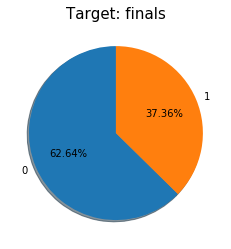

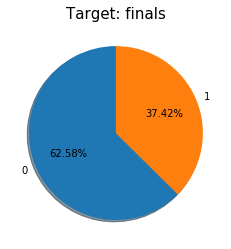

In [14]:
train_label_count = analysis_on_target(train)
test_label_count = analysis_on_target(test)

In [15]:
target = 'finals'
features = df.columns.drop([target, 'placement', 'units'])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_true = test[target]

In [16]:
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_estimators=100, random_state=2, oob_score=True)
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', pipe.score(X_val, y_val))
print('검증 f1: ', f1_score(y_val, y_pred))




검증 정확도:  0.8973158551810237
검증 f1:  0.8622085718274467


In [17]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
def fit_trees(X_train, y_train):
    pipe = None    # pipe = make_pipeline(...)
    clf = None     # clf = RandomizedSearchCV(pipe, ...)

    # YOUR CODE HERE

    ## encoder, imputer, 모델을 포함하는 하나의 학습 파이프라인
    pipe = make_pipeline(
        OrdinalEncoder(),
        RandomForestClassifier(n_estimators=300, random_state=2)
    )

    ## 적어도 두 개 이상의 하이퍼파라미터
    dists = {
        'randomforestclassifier__max_depth': [5,10,15,20,None],
        'randomforestclassifier__max_features' : uniform(0, 1),
    }
    ## RandomizedSearchCV
    clf = RandomizedSearchCV(
        pipe, ## 파이프라인
        param_distributions=dists, ## 탐색할 하이퍼파라미터
        n_iter=3, ## n_iter 10회 이하
        cv=4, ## cv 5 이하
        scoring='f1',
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    ## 훈련데이터로 학습
    clf.fit(X_train, y_train)
    # YOUR CODE ENDS HERE

    return clf

In [18]:
clf = fit_trees(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [19]:
print("Best CV F1", clf.best_score_)
print("Best CV params", clf.best_params_)

Best CV F1 0.859584146866331
Best CV params {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 0.596850157946487, 'randomforestclassifier__n_estimators': 171}


In [20]:
from sklearn.metrics import classification_report
def predict(X, y, best_estimator):
    y_pred_proba = None

    # YOUR CODE HERE
    y_pred_proba = best_estimator.predict_proba(X)[:,1]
    
    # YOUR CODE ENDS HERE

    report = classification_report(y, y_pred_proba > 0.5)
    return y_pred_proba, report

              precision    recall  f1-score   support

       False       0.90      0.93      0.92      3342
        True       0.87      0.84      0.85      1998

    accuracy                           0.89      5340
   macro avg       0.89      0.88      0.89      5340
weighted avg       0.89      0.89      0.89      5340



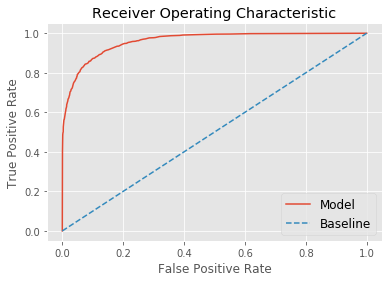

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score

y_test = y_true
def plot_roc(y, y_pred_proba):
    auc_score = roc_auc_score(y, y_pred_proba)
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    baseline_fpr, baseline_tpr, _ = roc_curve(y, [0] * len(y))

    plt.style.use("ggplot")
    plt.plot(fpr, tpr, label="Model")
    plt.plot(baseline_fpr, baseline_tpr, linestyle="--", label="Baseline")
    plt.xlabel("False Positive Rate", size=12)
    plt.ylabel("True Positive Rate", size=12)
    plt.title("Receiver Operating Characteristic")
    plt.legend(prop={"size": 12})
    plt.show()
    return auc_score


y_test_pred_proba, report = predict(X_test, y_test, clf.best_estimator_)
print(report)
auc_score = plot_roc(y_test, y_test_pred_proba)

In [22]:
print("Test AUC:", auc_score)

Test AUC: 0.9601958331760845


In [23]:
pipeline = clf.best_estimator_

# TODO: pipeline을 preprocess_pipeline과 model로 나눠 주세요.
preprocess_pipeline = None
model = None
# YOUR CODE HERE
from sklearn.pipeline import Pipeline
encoder = pipeline.named_steps['ordinalencoder']
model = pipeline.named_steps['randomforestclassifier']

pipe = Pipeline([
    ('preprocessing', make_pipeline(encoder)),
    ('rf', model) 
])

preprocess_pipeline = pipe.named_steps['preprocessing']
model = pipe.named_steps['rf']

# YOUR CODE ENDS HERE

# TODO: X_test를 preprocess_pipeline에 통과시켜 X_test_preprocessed를 만드세요.
X_test_preprocessed = None
# YOUR CODE HERE
X_test_preprocessed = preprocess_pipeline.transform(X_test)
# YOUR CODE ENDS HERE

In [24]:
import eli5
from eli5.sklearn import PermutationImportance


def get_permutation_importance(X, y, model):
    permuter = None
    # permuter = PermutationImportance(..., n_iter=5, random_state=42)

    # YOUR CODE HERE
    permuter = PermutationImportance(
        pipe.named_steps['rf'], # model
        scoring='roc_auc', # metric
        n_iter=5, # 다른 random seed를 사용하여 5번 반복
    )
    
    # YOUR CODE ENDS HERE
    permuter.fit(X, y)

    return permuter

In [25]:
permuter = get_permutation_importance(X_test_preprocessed, y_test, model)

In [26]:
zip(X_test.columns, permuter.feature_importances_)

In [27]:
permuter.feature_importances_

array([ 4.09475903e-04,  1.49910533e-05, -3.09825085e-04,  4.05090908e-03,
       -3.07758387e-05,  2.02272919e-01,  4.50768542e-02,  2.32249005e-04,
        4.83697342e-04,  1.68016610e-04,  3.64218198e-04,  9.62385186e-03,
        2.12869962e-04,  7.09102280e-04])

In [28]:
permuter = get_permutation_importance(X_test_preprocessed, y_test, model)
eli5.show_weights(permuter, top=None, feature_names=X_test.columns.tolist())
print("Top3 Important Features:")
p_i = sorted(
    list(zip(X_test.columns.tolist(), permuter.feature_importances_)),
    key=lambda x: x[1],
    reverse=True,
)
print(p_i[:3])

Top3 Important Features:
[('total_damage_to_players', 0.20609482911996374), ('players_eliminated', 0.046724477319929125), ('cost_sum', 0.008925786947929337)]


In [29]:
p_i

[('total_damage_to_players', 0.20609482911996374),
 ('players_eliminated', 0.046724477319929125),
 ('cost_sum', 0.008925786947929337),
 ('level', 0.0036729278650283526),
 ('high_cost_ratio', 0.001084402775007165),
 ('main_synergy', 0.00032695771774158275),
 ('num_activated_synergy', 0.0002865223092630931),
 ('augment1', 0.0002244015409783806),
 ('main_synergy_score', 0.0001782602470812744),
 ('total_synergy_score', 0.00011941923970639756),
 ('high_cost_sum', 0.00010198708582898064),
 ('augment2', -9.472368838023826e-05),
 ('gold_left', -0.00027004862432755683),
 ('augment3', -0.0003522223600022301)]

In [30]:
# 테스트셋 예측 결과 계산하는 함수
def calculate_score(pipe, X_test, y_test):
    test_accuracy = pipe.score(X_test, y_test)
    test_f1 = f1_score(y_test, pipe.predict(X_test))
    return test_accuracy, test_f1

In [31]:
test_accuracy, test_f1 = calculate_score(clf.best_estimator_, X_test, y_test)

In [32]:
print("test accuracy: ", test_accuracy)
print("test F1:", test_f1)

test accuracy:  0.8938202247191012
test F1: 0.8548758638341438


In [37]:
from pdpbox.pdp import pdp_isolate, pdp_plot


def get_pdp_isolated(dataset, model, feature):
    pdp_isolated = None

    # YOUR CODE HERE
    pdp_isolated = pdp_isolate(
        model=model, 
        dataset=dataset, 
        model_features=dataset.columns, 
        feature=feature,
        grid_type='percentile', # default='percentile', or 'equal'
        num_grid_points=50 # default=10
    )
    
    # YOUR CODE ENDS HERE

    return pdp_isolated

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6dfc52e3d0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6dfaccfaf0>})

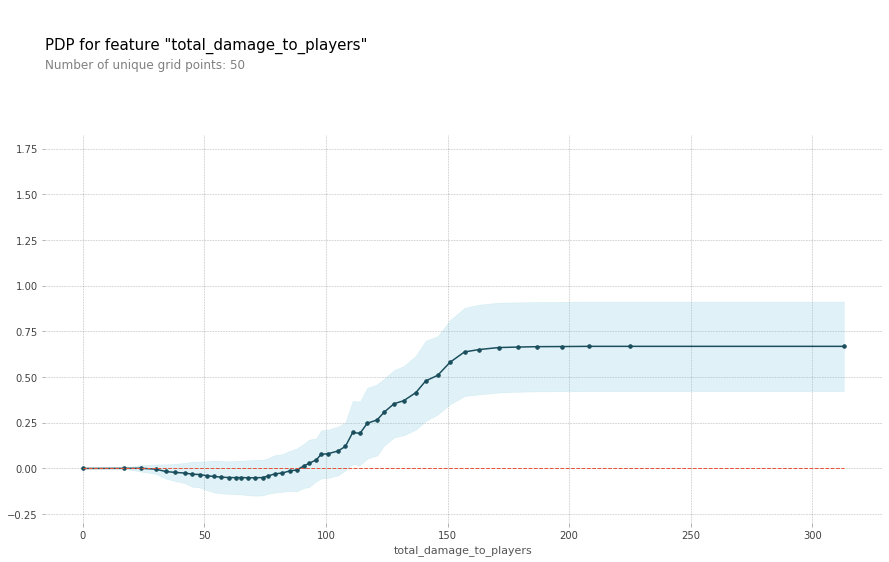

In [38]:
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=X_test.columns)
feature = sorted(p_i, key=lambda x: x[1], reverse=True)[0][0]
pdp_isolated = get_pdp_isolated(X_test_preprocessed_df, model, feature)
pdp_plot(pdp_isolated, feature_name=feature)

In [35]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot


def get_pdp_interaction(dataset, model, features):
    pdp_interaction = None

    # YOUR CODE HERE
    pdp_interaction = pdp_interact(
        model = model, 
        dataset = dataset,
        model_features = dataset.columns, 
        features = features
    )
    
    # YOUR CODE ENDS HERE

    return pdp_interaction

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6dfcafd040>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6dfc6cbe20>})

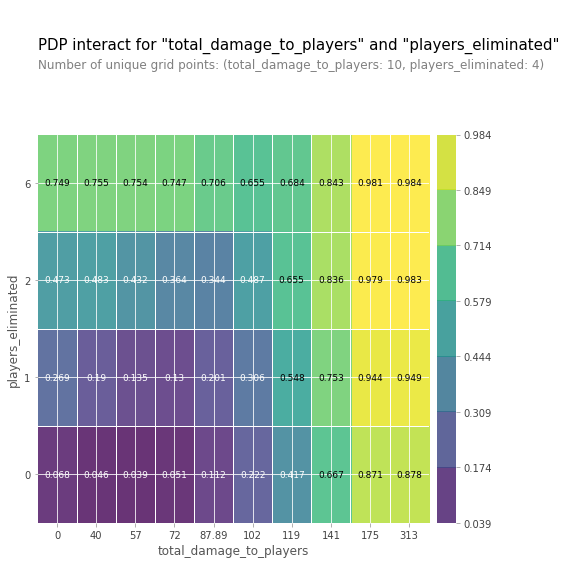

In [36]:
features = list(map(lambda x: x[0], sorted(p_i, key=lambda x: x[1], reverse=True)))[:2]
pdp_interaction = get_pdp_interaction(X_test_preprocessed_df, model, features)
pdp_interact_plot(pdp_interaction, feature_names=features, plot_type="grid")